# Week 3, Lecture 2: Data Cleaning and Preprocessing
## CS 2100/4700: Introduction to Machine Learning

**Duration:** 1 hour 15 minutes 
**Goal:** Master the foundational skills of preparing data for machine learning

## Why This Lecture Matters

> "Garbage in, garbage out" — The oldest rule in data science

### The Reality of Machine Learning Work

**Real-world fact:** Spend **60-80%** of their time on data preparation, not model building.

| Activity | Time Spent | What It Involves |
|----------|------------|------------------|
| Data Cleaning & Prep | 60-80% | Finding issues, fixing errors, transforming data |
| Model Building | 10-20% | Selecting algorithms, training models |
| Model Evaluation | 10-20% | Testing, tuning, validating |

### Why Clean Data Matters
Flawed data leads to flawed insights.

| Scenario | Result |
|----------|--------|
| Dirty data + Simple model | ❌ Poor predictions |
| Dirty data + Complex model | ❌ Still poor predictions |
| **Clean data + Simple model** | ✅ Good predictions |
| Clean data + Complex model | ✅ Great predictions |

## Learning Objectives

By the end of this lecture, you will be able to:

1. Identify common data quality issues
2. Handle missing data using multiple strategies
3. Detect and remove duplicates
4. Convert data types appropriately
5. Apply scaling and normalization techniques
6. Build a complete data cleaning pipeline

## 1. Data Types and Structures

Before cleaning, you must understand what you're working with. Different data types require different handling.

### 1.1 The Basic Data Types in ML
Text data can be many things.

| Type | Description | Examples | Math Operations? | Pandas dtype |
|------|-------------|----------|------------------|-------------|
| **Numerical (Continuous)** | Measurable quantities | Age, salary, temperature | Yes | `float64` |
| **Numerical (Discrete)** | Countable integers | # of children, years of education | Yes | `int64` |
| **Categorical (Nominal)** | Categories with NO order | Color, country, occupation | No | `object` |
| **Categorical (Ordinal)** | Categories WITH order | Education level, satisfaction rating | Limited | `object` |

### 1.2 Why Data Types Matter for ML

| Algorithm | Handles Numeric? | Handles Categorical? | What You Must Do |
|-----------|------------------|---------------------|------------------|
| Linear Regression | Yes | No | Encode categories to numbers |
| Decision Trees | Yes | Yes (some) | May need encoding |
| K-Nearest Neighbors | Yes | No | Encode + scale |
| Neural Networks | Yes | No | Encode + scale |

### 1.2.1 Pandas Data Types
- Pandas dtypes: 
  - int
  - float
  - object -- usually needs conversion
    - categorical
    - text
  - datetime

### 1.3 Load the Dataset and Explore Types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
           'native_country', 'income']
df = pd.read_csv(url, names=columns, na_values='?', skipinitialspace=True)

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print("\nData Types:")
print(df.dtypes)

Dataset loaded: 32561 rows, 15 columns

Data Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object


String can be many things -- categorical (nominal or ordinal)

In [2]:

# Automatically separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns ({len(numeric_cols)}):")
for col in numeric_cols:
    print(f"  • {col}: {df[col].min()} to {df[col].max()}")

print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  • {col}: {df[col].nunique()} unique values")

Numeric columns (6):
  • age: 17 to 90
  • fnlwgt: 12285 to 1484705
  • education_num: 1 to 16
  • capital_gain: 0 to 99999
  • capital_loss: 0 to 4356
  • hours_per_week: 1 to 99

Categorical columns (9):
  • workclass: 8 unique values
  • education: 16 unique values
  • marital_status: 7 unique values
  • occupation: 14 unique values
  • relationship: 6 unique values
  • race: 5 unique values
  • sex: 2 unique values
  • native_country: 41 unique values
  • income: 2 unique values


### Exercise 1.1: Data Type Identification

Classify each column below. Fill in your answers:

| Column | Your Classification | Reasoning |
|--------|---------------------|----------|
| age | | |
| workclass | | |
| education | | |
| education_num | | |
| hours_per_week | | |
| income | | |

In [3]:
# Explore the columns to help with classification
print("Sample values for each column:")
print("\nage:", df['age'].head(5).tolist())
print("workclass:", df['workclass'].dropna().unique()[:5].tolist())
print("education:", df['education'].unique()[:5].tolist())
print("education_num:", sorted(df['education_num'].unique())[:5])
print("hours_per_week:", df['hours_per_week'].head(5).tolist())
print("income:", df['income'].unique().tolist())

Sample values for each column:

age: [39, 50, 38, 53, 28]
workclass: ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov']
education: ['Bachelors', 'HS-grad', '11th', 'Masters', '9th']
education_num: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
hours_per_week: [40, 13, 40, 40, 40]
income: ['<=50K', '>50K']


<details>
<summary>Click for Answers</summary>

| Column | Classification | Reasoning |
|--------|----------------|----------|
| age | Numerical Discrete | Whole years, countable |
| workclass | Categorical Nominal | No natural order between Private, Government, etc. |
| education | Categorical Ordinal | Has natural order: HS < Bachelor < Master |
| education_num | Numerical Discrete | Numeric representation of education (1-16) |
| hours_per_week | Numerical Discrete | Whole hours |
| income | Categorical Nominal | Binary outcome |

</details>

## 2. The Data Cleaning Pipeline

### 2.1 Visual Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    DATA CLEANING PIPELINE                       │
├─────────────────────────────────────────────────────────────────┤
│  ASSESS    ->     CLEAN   ->   TRANSFORM  ->   VALIDATE         │
│                                                                 │
│  • Shape       • Missing      • Encoding     • No nulls         │
│  • Types       • Duplicates   • Scaling      • Correct types    │
│  • Missing %   • Outliers     • Features     • Ready for ML     │
└─────────────────────────────────────────────────────────────────┘
```

### 2.2 Step 1: Data Assessment

- Understanding the data: shape, head/tail/sample, info, describe (include='all')
- Identify core quality issues: missing (isnull().sum()), duplicates (duplicated()), weird values ("?", negative ages), outliers
- Adult: "?" in workclass, occupation, native-country (~7% missing in some)

In [4]:
def assess_data(df):
    """
    Comprehensive data assessment function.
    Run this FIRST on any new dataset.
    """
    print("="*60)
    print("               DATA ASSESSMENT REPORT")
    print("="*60)
    
    # Basic info
    print(f"\nBASIC INFO")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print(f"\nDATA TYPES")
    type_counts = df.dtypes.value_counts()
    for dtype, count in type_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # Missing values
    print(f"\nMISSING VALUES")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    if missing.sum() == 0:
        print("   No missing values!")
    else:
        for col in missing[missing > 0].index:
            print(f"   {col}: {missing[col]:,} ({missing_pct[col]}%)")
    
    # Duplicates
    print(f"\n DUPLICATES")
    dup_count = df.duplicated().sum()
    if dup_count == 0:
        print(" No duplicate rows!")
    else:
        print(f"   {dup_count:,} duplicate rows ({dup_count/len(df)*100:.2f}%)")
    
    print("\n" + "="*60)

# Run assessment
assess_data(df)

               DATA ASSESSMENT REPORT

BASIC INFO
   Rows: 32,561
   Columns: 15
   Memory: 19.78 MB

DATA TYPES
   object: 9 columns
   int64: 6 columns

MISSING VALUES
   workclass: 1,836 (5.64%)
   occupation: 1,843 (5.66%)
   native_country: 583 (1.79%)

 DUPLICATES
   24 duplicate rows (0.07%)



### Exercise 2.1: Data Assessment Questions

Based on the assessment above, answer:

1. How many total missing values are there?
2. Which column has the most missing values?
3. What percentage of data is missing from that column?
4. Are there any duplicate rows?

In [8]:
# Your code to verify your answers
print("1. Total missing values:", df.isnull().sum().sum())

# 2. Column with most missing (fill in)
missing = df.isnull().sum()
print("2. Column with most missing:", missing.idxmax())

# 3. Percentage missing (fill in)
print("3. Percentage:", (missing.max() / len(df) * 100).round(2), "%")

# 4. Duplicates
print("4. Duplicate rows:", df.duplicated().sum())

1. Total missing values: 4262
2. Column with most missing: occupation
3. Percentage: 5.66 %
4. Duplicate rows: 24


## 3. Handling Missing Data

### 3.1 The Golden Rule

> **ALWAYS understand WHY data is missing before deciding how to handle it.**

### 3.2 Types of Missing Data

| Type | Meaning | Best Strategy |
|------|---------|---------------|
| **MCAR** | Missing Completely At Random | Any method works |
| **MAR** | Missing At Random (related to other data) | Impute using related features |
| **MNAR** | Missing Not At Random (related to missing value itself) | Requires domain expertise |

### 3.3 Detecting Missing Values

In [9]:
# Method 1: Count missing per column
print("Missing values per column:")
print(df.isnull().sum())

# Method 2: Percentage missing
print("\nPercentage missing:")
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print(missing_pct[missing_pct > 0])

Missing values per column:
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

Percentage missing:
workclass         5.64
occupation        5.66
native_country    1.79
dtype: float64


### 3.4 Visualizing Missing Data

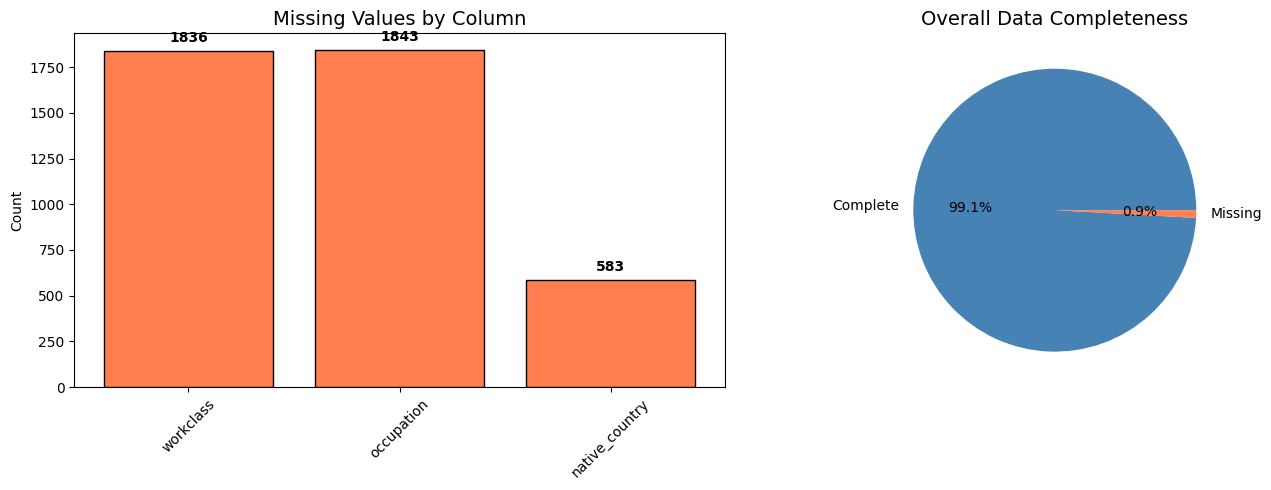

In [5]:
# Create missing data visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of missing counts
missing = df.isnull().sum()
missing = missing[missing > 0]
axes[0].bar(missing.index, missing.values, color='coral', edgecolor='black')
axes[0].set_title('Missing Values by Column', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, v in enumerate(missing.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart showing missing vs complete
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
complete_cells = total_cells - missing_cells
axes[1].pie([complete_cells, missing_cells], 
            labels=['Complete', 'Missing'],
            autopct='%1.1f%%',
            colors=['steelblue', 'coral'])
axes[1].set_title('Overall Data Completeness', fontsize=14)

plt.tight_layout()
plt.show()

### 3.5 Strategy 1: DELETE (Listwise Deletion)

**When to use:**
- Missing data is less than 5% of rows; or 70% or more of a column is missing
- Data is MCAR (missing completely at random)
- You have plenty of data to spare

**When NOT to use:**
- Missing data is more than 10%
- You have limited data

In [11]:
# Check how much data we'd lose
print(f"Rows before: {len(df)}")
print(f"Rows with any missing: {df.isnull().any(axis=1).sum()}")
print(f"Percentage that would be deleted: {df.isnull().any(axis=1).sum()/len(df)*100:.1f}%")

# Option A: Drop ALL rows with ANY missing value
df_dropped_all = df.dropna()
print(f"\nAfter dropna(): {len(df_dropped_all)} rows remain")

Rows before: 32561
Rows with any missing: 2399
Percentage that would be deleted: 7.4%

After dropna(): 30162 rows remain


### 3.6 Strategy 2: IMPUTE (Fill with Statistics)

| Method | Best For | Code |
|--------|----------|------|
| **Mean** | Numeric, symmetric distribution | `fillna(df['col'].mean())` |
| **Median** | Numeric, skewed distribution | `fillna(df['col'].median())` |
| **Mode** | Categorical data | `fillna(df['col'].mode()[0])` |

In [12]:
# Create a copy to work with
df_imputed = df.copy()

# For categorical columns: fill with mode (most frequent value)
print("Mode values for categorical columns:")
for col in ['workclass', 'occupation', 'native_country']:
    mode_val = df_imputed[col].mode()[0]
    missing_count = df_imputed[col].isnull().sum()
    print(f"  {col}: mode = '{mode_val}' (filling {missing_count} values)")
    df_imputed[col] = df_imputed[col].fillna(mode_val)

# Verify
print(f"\nMissing values after imputation: {df_imputed.isnull().sum().sum()}")

Mode values for categorical columns:
  workclass: mode = 'Private' (filling 1836 values)
  occupation: mode = 'Prof-specialty' (filling 1843 values)
  native_country: mode = 'United-States' (filling 583 values)

Missing values after imputation: 0


### 3.7 Strategy 3: PREDICT (Advanced Imputation)

In [6]:
from sklearn.impute import KNNImputer

# KNN Imputer: Uses K-nearest neighbors to impute
# Only works with numeric data
numeric_df = df[['age', 'education_num', 'capital_gain', 
                  'capital_loss', 'hours_per_week']].copy()

print("Before KNN imputation:")
print(numeric_df.isnull().sum())

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
numeric_imputed = pd.DataFrame(
    knn_imputer.fit_transform(numeric_df),
    columns=numeric_df.columns
)

print("\nAfter KNN imputation:")
print(numeric_imputed.isnull().sum())

Before KNN imputation:
age               0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

After KNN imputation:
age               0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64


### Exercise 3.1: Handle Missing Values

Complete the following tasks:

In [14]:
# Task 1: Calculate the percentage of missing values for each column
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Columns with missing values:")
print(missing_pct[missing_pct > 0])

# Task 2: Implement imputation strategy
df_clean = df.copy()

# Fill in the code to impute missing values with mode
# YOUR CODE HERE
df_clean['workclass'] = df_clean['workclass'].fillna(df_clean['workclass'].mode()[0])
df_clean['occupation'] = df_clean['occupation'].fillna(df_clean['occupation'].mode()[0])
df_clean['native_country'] = df_clean['native_country'].fillna(df_clean['native_country'].mode()[0])

# Task 3: Verify no missing values remain
print(f"\nMissing values remaining: {df_clean.isnull().sum().sum()}")

Columns with missing values:
workclass         5.64
occupation        5.66
native_country    1.79
dtype: float64

Missing values remaining: 0


## 4. Handling Duplicates

### 4.1 Why Duplicates Are Problematic

| Problem | Explanation | Impact |
|---------|-------------|--------|
| **Training Bias** | Model sees same example multiple times | Overweights that example |
| **Data Leakage** | Same record in train AND test sets | Inflated accuracy |
| **Wasted Resources** | Processing same data twice | Slower training |

In [15]:
# Count exact duplicates
dup_count = df_clean.duplicated().sum()
print(f"Exact duplicate rows: {dup_count}")

# View the duplicate rows
if dup_count > 0:
    print("\nSample duplicate rows:")
    duplicates = df_clean[df_clean.duplicated(keep=False)]
    print(duplicates.head(10))

Exact duplicate rows: 24

Sample duplicate rows:
      age workclass  fnlwgt     education  education_num      marital_status  \
2303   90   Private   52386  Some-college             10       Never-married   
3917   19   Private  251579  Some-college             10       Never-married   
4325   25   Private  308144     Bachelors             13       Never-married   
4767   21   Private  250051  Some-college             10       Never-married   
4881   25   Private  308144     Bachelors             13       Never-married   
4940   38   Private  207202       HS-grad              9  Married-civ-spouse   
5104   90   Private   52386  Some-college             10       Never-married   
5579   27   Private  255582       HS-grad              9       Never-married   
5805   20   Private  107658  Some-college             10       Never-married   
5842   25   Private  195994       1st-4th              2       Never-married   

             occupation   relationship                race     sex  \


In [16]:
# Remove duplicates
print(f"Shape before: {df_clean.shape}")

df_clean = df_clean.drop_duplicates(keep='first')

print(f"Shape after: {df_clean.shape}")
print(f"Duplicates remaining: {df_clean.duplicated().sum()}")

Shape before: (32561, 15)
Shape after: (32537, 15)
Duplicates remaining: 0


### Exercise 4.1: Duplicate Detection

In [17]:
# Task 1: Check for partial duplicates where age, sex, and income are the same
partial_key = ['age', 'sex', 'income']
partial_dups = df_clean.duplicated(subset=partial_key).sum()
print(f"Partial duplicates (same age, sex, income): {partial_dups}")

# Task 2: What percentage of rows are partial duplicates?
partial_pct = (partial_dups / len(df_clean) * 100).round(2)
print(f"Percentage: {partial_pct}%")

Partial duplicates (same age, sex, income): 32270
Percentage: 99.18%


## 5. Data Type Conversion

### 5.1 Why Data Types Matter

| Problem | Example | Consequence |
|---------|---------|-------------|
| Numbers as strings | `"50000"` instead of `50000` | Can't calculate mean |
| Categories as strings | `"Male"`, `"Female"` | Uses more memory |

In [ ]:
# Check current memory usage
print(f"Memory before optimization: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Convert categorical columns to 'category' dtype
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype('category')

# Check memory after
print(f"Memory after optimization: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

### 5.2 Encoding Categorical Variables

ML algorithms need numbers. Here's how to convert categories:

| Method | Use When |
|--------|----------|
| **Label Encoding** | Categories have natural order |
| **One-Hot Encoding** | Categories have NO order, few categories |

In [18]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for binary column (sex)
le = LabelEncoder()
df_clean['sex_encoded'] = le.fit_transform(df_clean['sex'])

# See the mapping
print("Label Encoding for 'sex':")
print(df_clean[['sex', 'sex_encoded']].drop_duplicates())

Label Encoding for 'sex':
      sex  sex_encoded
0    Male            1
4  Female            0


In [19]:
# One-hot encoding creates a new column for each category
df_onehot = pd.get_dummies(df_clean[['workclass']], prefix='workclass')
print("One-Hot Encoding for 'workclass':")
print(df_onehot.head())
print(f"\nCreated {df_onehot.shape[1]} new columns")

One-Hot Encoding for 'workclass':
   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                  False                False                   False   
1                  False                False                   False   
2                  False                False                   False   
3                  False                False                   False   
4                  False                False                   False   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0              False                   False                       False   
1              False                   False                        True   
2               True                   False                       False   
3               True                   False                       False   
4               True                   False                       False   

   workclass_State-gov  workclass_Without-pay  
0                 True

### Exercise 5.1: Encoding Practice

In [ ]:
# Task 1: Create binary encoding for income (target variable)
# >50K should be 1, <=50K should be 0
df_clean['income_binary'] = (df_clean['income'] == '>50K').astype(int)
print("Income encoding:")
print(df_clean[['income', 'income_binary']].drop_duplicates())

# Task 2: How many high earners (income_binary = 1) are there?
print(f"\nHigh earners: {df_clean['income_binary'].sum()}")
print(f"Percentage: {df_clean['income_binary'].mean() * 100:.1f}%")

## 6. Data Transformation: Scaling

### 6.1 Why Scaling Matters

**The Problem:** Features have different scales.

| Feature | Range |
|---------|-------|
| Age | 17-90 |
| Capital Gain | 0-99,999 |

Without scaling, capital_gain dominates distance-based algorithms!

### 6.2 Scaling Methods

| Scaler | Formula | Best For |
|--------|---------|----------|
| **MinMaxScaler** | (x - min) / (max - min) | Neural networks |
| **StandardScaler** | (x - mean) / std | Most algorithms |
| **RobustScaler** | (x - median) / IQR | Data with outliers |

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Select features with different scales
X = df_clean[['age', 'hours_per_week', 'capital_gain']].copy()

# Apply each scaler
scalers = {
    'Original': X.values,
    'MinMaxScaler': MinMaxScaler().fit_transform(X),
    'StandardScaler': StandardScaler().fit_transform(X),
    'RobustScaler': RobustScaler().fit_transform(X)
}

# Create comparison visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (name, data) in zip(axes, scalers.items()):
    ax.boxplot(data)
    ax.set_title(f'{name}')
    ax.set_xticklabels(['age', 'hours', 'cap_gain'], fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler
numeric_features = ['age', 'education_num', 'capital_gain', 
                    'capital_loss', 'hours_per_week']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[numeric_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features)

# Compare before and after
print("BEFORE scaling:")
print(df_clean[numeric_features].describe().loc[['mean', 'std', 'min', 'max']].round(2))

print("\nAFTER StandardScaler:")
print(X_scaled_df.describe().loc[['mean', 'std', 'min', 'max']].round(2))

### Exercise 6.1: Scaling Practice

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Create a small dataset with outliers
data = pd.DataFrame({
    'age': [25, 30, 35, 40, 45, 90],  # 90 is an outlier
    'income': [30000, 45000, 55000, 65000, 80000, 200000]  # 200000 is an outlier
})

print("Original data:")
print(data)

# Task 1: Apply MinMaxScaler
minmax = MinMaxScaler()
data_minmax = pd.DataFrame(minmax.fit_transform(data), columns=data.columns)
print("\nMinMaxScaler result:")
print(data_minmax.round(3))

# Task 2: Apply RobustScaler
robust = RobustScaler()
data_robust = pd.DataFrame(robust.fit_transform(data), columns=data.columns)
print("\nRobustScaler result:")
print(data_robust.round(3))

# Question: Which scaler handled the outliers better?

## 7. Complete Data Cleaning Pipeline

### 7.1 Putting It All Together

In [ ]:
def clean_adult_data(df, verbose=True):
    """
    Complete data cleaning pipeline for Adult dataset.
    """
    df_clean = df.copy()
    
    if verbose:
        print("="*60)
        print("Starting Data Cleaning Pipeline")
        print("="*60)
        print(f"Initial shape: {df_clean.shape}")
    
    # Step 1: Handle missing values
    if verbose:
        print("\n[Step 1] Handling missing values...")
    for col in ['workclass', 'occupation', 'native_country']:
        mode_val = df_clean[col].mode()[0]
        missing_count = df_clean[col].isnull().sum()
        df_clean[col] = df_clean[col].fillna(mode_val)
        if verbose:
            print(f"   Filled {missing_count} missing in '{col}'")
    
    # Step 2: Remove duplicates
    if verbose:
        print("\n[Step 2] Removing duplicates...")
    dup_count = df_clean.duplicated().sum()
    df_clean = df_clean.drop_duplicates()
    if verbose:
        print(f"   Removed {dup_count} duplicate rows")
    
    # Step 3: Convert data types
    if verbose:
        print("\n[Step 3] Converting data types...")
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_clean[col] = df_clean[col].astype('category')
    if verbose:
        print(f"   Converted {len(categorical_cols)} columns to 'category'")
    
    # Step 4: Create binary target
    if verbose:
        print("\n[Step 4] Creating binary target...")
    df_clean['income_binary'] = (df_clean['income'] == '>50K').astype(int)
    if verbose:
        print(f"   Created 'income_binary': {df_clean['income_binary'].sum()} positive cases")
    
    # Final report
    if verbose:
        print("\n" + "="*60)
        print("Pipeline Complete!")
        print("="*60)
        print(f"Final shape: {df_clean.shape}")
        print(f"Missing values: {df_clean.isnull().sum().sum()}")
    
    return df_clean

# Run the pipeline
df_final = clean_adult_data(df)

In [ ]:
# Final verification
print("\n" + "="*60)
print("FINAL VERIFICATION")
print("="*60)

print(f"\n✓ Shape: {df_final.shape}")
print(f"✓ Missing values: {df_final.isnull().sum().sum()}")
print(f"✓ Duplicates: {df_final.duplicated().sum()}")
print(f"\n✓ Target distribution:")
print(df_final['income_binary'].value_counts())
print(f"\n✓ First few rows:")
df_final.head()

## Summary: Quick Reference

### Data Assessment
```python
df.shape                    # Rows and columns
df.dtypes                   # Data types
df.isnull().sum()           # Missing counts
df.duplicated().sum()       # Duplicate count
```

### Missing Values
```python
df.dropna()                              # Delete rows
df['col'].fillna(df['col'].mode()[0])    # Fill with mode
```

### Duplicates
```python
df.drop_duplicates()                     # Remove duplicates
```

### Encoding
```python
pd.get_dummies(df, columns=['col'])      # One-hot encoding
(df['col'] == 'value').astype(int)       # Binary encoding
```

### Scaling
```python
StandardScaler().fit_transform(X)        # Standard scaling
```

---

*Week 3, Lecture 2 — CS 2100/4700: Introduction to Machine Learning*